In [1]:
library(pracma)
library(plotly)
#load source file
src.path <- "../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utility.R", sep="/"))

source(paste(src.path, "Estimation", "cca_estimation.R", sep="/"))
library(viridis)
library(fields)

 要求されたパッケージ ggplot2 をロード中です 


 次のパッケージを付け加えます: ‘plotly’ 


 以下のオブジェクトは ‘package:ggplot2’ からマスクされています: 

     last_plot 


 以下のオブジェクトは ‘package:stats’ からマスクされています: 

     filter 


 以下のオブジェクトは ‘package:graphics’ からマスクされています: 

     layout 


 要求されたパッケージ splines をロード中です 

 要求されたパッケージ Matrix をロード中です 


 次のパッケージを付け加えます: ‘Matrix’ 


 以下のオブジェクトは ‘package:pracma’ からマスクされています: 

     expm, lu, tril, triu 


 要求されたパッケージ fds をロード中です 

 要求されたパッケージ rainbow をロード中です 

 要求されたパッケージ MASS をロード中です 


 次のパッケージを付け加えます: ‘MASS’ 


 以下のオブジェクトは ‘package:plotly’ からマスクされています: 

     select 


 要求されたパッケージ pcaPP をロード中です 

 要求されたパッケージ RCurl をロード中です 

 要求されたパッケージ deSolve をロード中です 


 次のパッケージを付け加えます: ‘deSolve’ 


 以下のオブジェクトは ‘package:pracma’ からマスクされています: 

     rk4 



 次のパッケージを付け加えます: ‘fda’ 


 以下のオブジェクトは ‘package:graphics’ からマスクされています: 

     matplot 


 要求されたパッケージ viridisLite をロード中です 

 要求されたパッケージ spam をロード中です 

 要求されたパッケージ dotCall64 をロード中です 

 要求されたパッケージ grid をロード中です 

Spam version 2.7-0 (2021-06-25) is loaded.
T

In [2]:
cross.cov <- function(obj1,obj2, basis1, basis2, lambda1, lambda2, ncan=NULL){
    ###################
    # obj1: functional object1
    # obj2: functional object1
    # basis1: funcational basis object 1
    # basis2: functional basis object 2
    ###################
    

    score1 <- inprod(obj1, basis1)
    n <- dim(score1)[1]
    #inv_score1 <-  diag(1 / sqrt(lambda1))
    score1 <- score1# %*% inv_score1

    score2 <- inprod(obj2, basis2)
    #inv_score2 <- diag(1 / sqrt(lambda2))
    score2 <- score2 #%*% inv_score2

    D.matrix <- (t(score1) %*% score2)/n
    return(D.matrix)

}

In [10]:
n <- 100
p <- 50
k.gen <- 15
M <- 2
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(15,15)

In [12]:
##data generation process 1##
# generate latent covariance matrix
cov <- solve(synth.omega.tridiag3(p,k.gen))
# generate Amatrix, Noisematrix, basis matrix
Apinv_list <- list()
N_list <- list()
basis.m_list <- list()


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen,km.gen[m], min(km.gen[m],k.gen), scale=2)
    #Am <- synth.linear_op.identity(k)
    
    Apinv_list[[m]] <- pinv(Am)
    N_list[[m]] <- diag(p*km.gen[m])
    basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])
}



data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list,N_list, dependent=FALSE, addnoise=FALSE)

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"


In [13]:
##compute mean of the data across p
data_mean <- utility.mean_data(data) # n \times p
##compute functional basis of each modality
fbasis_list <- list()

km.est <- km.gen
for(i in 1:length(km.est)){
    
    if(km.est[i]  > k.gen){
        km.est[i] <- k.gen
    }
}

k.est <- min(km.est)
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors
}

[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"


In [14]:
km.est

[1] 15 15

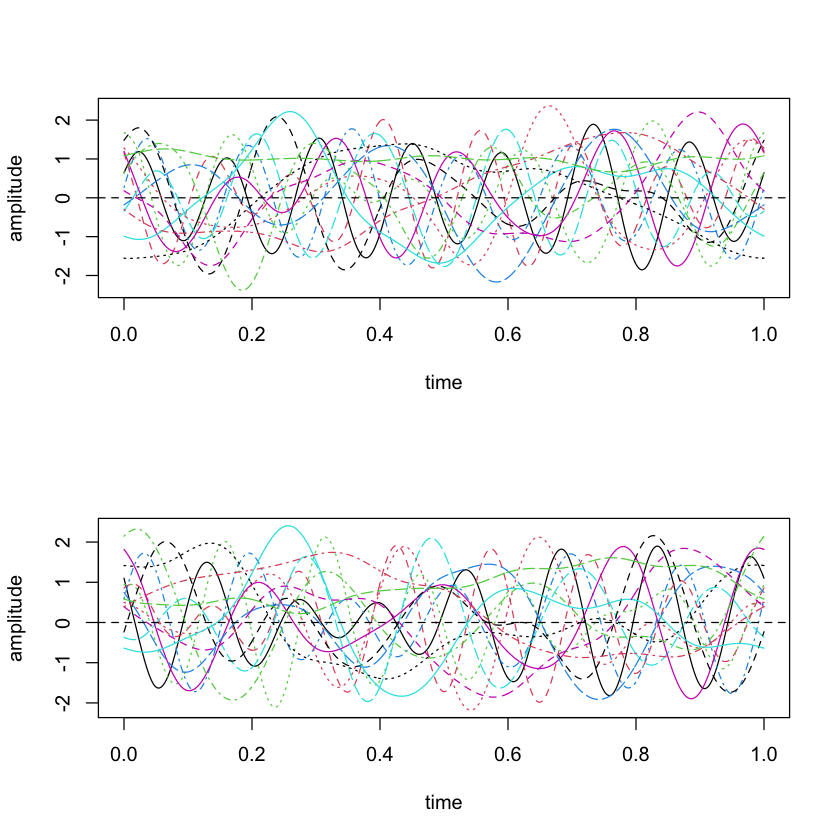

In [15]:
par(bg="white", mfrow=c(2,1))
for(m in 1:M){    

    plot(fbasis_list[[m]], xlab="time", ylab="amplitude",
        sub=paste("Estimated functional basis of data modaltiy", m))
}

In [16]:
#test whether construction to different basis would change the reulst
d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])

bspline.basis <- create.bspline.basis(rangeval=c(0,1), nbasis=km.est[1]*3)
d12 <- Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=bspline.basis)

result <- all.equal(eval.fd(obs.time,d1),eval.fd(obs.time,d12))
print(paste("Projection to different basis yields same result:", result))

[1] "Projection to different basis yields same result: TRUE"


In [17]:
#data modality 1
d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])
#data modality 2
d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=fbasis_list[[2]])

### Canonical Correlation Analysis
Remember to set the data generation to be ``dependent``. If set ``indepdendent``, the resulting canonical correlation would go to zero as $n$ goes to inifinity, which matches the thoery. 

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"


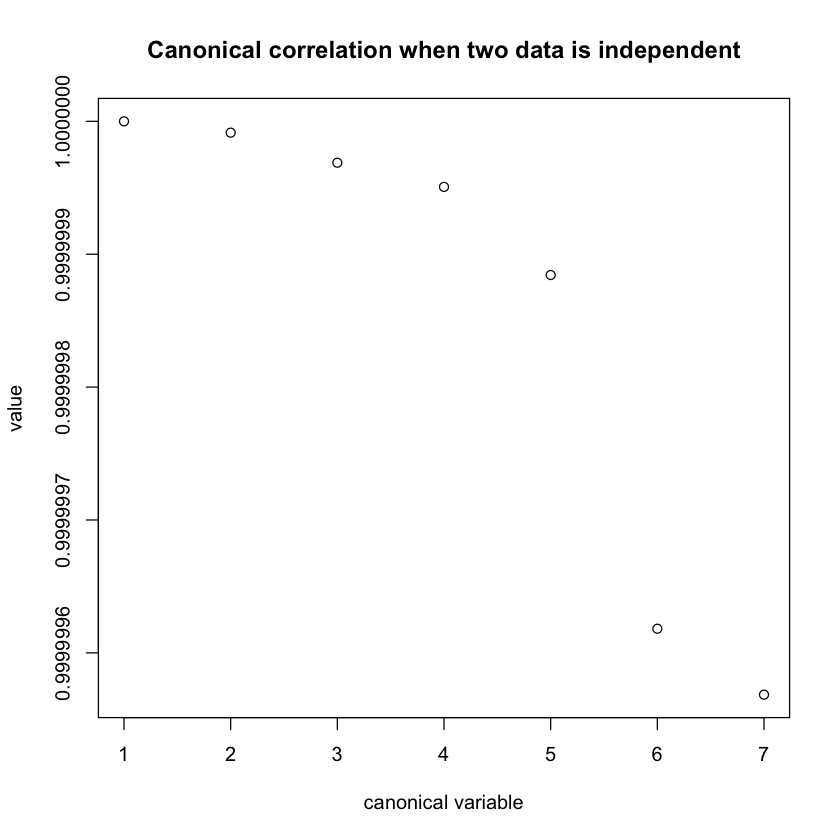

In [147]:
#remember to set the cca value to be dependent data, the results quite differ a lot


n <- 1000 #vary this to see the outcomes
p <- 2
k <- 7
M <- 2
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km1 <- c(7,7)

##data generation process 1##
# generate latent covariance matrix
cov <- solve(synth.omega.tridiag4(p,k))
# generate Amatrix, Noisematrix, basis matrix
Apinv_list <- list()
N_list <- list()
basis.m_list <- list()


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k,km1[m], min(km1[m],k), scale=1)
    #Am <- synth.linear_op.identity(k)
    
    Apinv_list[[m]] <- pinv(Am)
    N_list[[m]] <- diag(p*km1[m])*0.
    basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km1[m])
}

km.est <- km.gen
for(i in 1:length(km.est)){
    
    if(km.est[i]  > k.gen){
        km.est[i] <- k.gen
    }
}

k.est <- min(km.est)

data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list,N_list, dependent=TRUE, addnoise=FALSE)
##compute mean of the data across p
data_mean <- utility.mean_data(data) # n \times p
##compute functional basis of each modality
fbasis_list <- list()
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors
}
#data modality 1
d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])
#data modality 2
d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=fbasis_list[[2]])
k_est <- min(km1[1],km1[2])
ccoar <- cca.fd(d1, d2, ncan = k_est)$ccacorr[1:k_est]
par(bg="white")
plot(ccoar,xlab="canonical variable", ylab="value",main="Canonical correlation when two data is independent")

In [8]:
#remember to set the cca value to be dependent data, the results quite differ a lot


n <- 200 #vary this to see the outcomes
p <- 2
k.gen <- 7
M <- 2
obs.time <- seq(0,1,1/20)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(7, 7)
##data generation process 1##
# generate latent covariance matrix
cov <- solve(synth.omega.tridiag5(p, k.gen))
# generate Amatrix, Noisematrix, basis matrix
Apinv_list <- list()
A_list <- list()
N_list <- list()
basis.m_list <- list()
true.basis_list <- list()
true.values_list <- list()


for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen, km.gen[m], floor(min(km.gen[m],k.gen)/3), scale=1)
    Am <- t(t(Am) %*% diag((1:k.gen)))
    #Am <- synth.linear_op.identity(k.gen)
    #Am <- synth.linear_op.orthogonal(k.gen,km.gen[m])
    #for(j in 1:k.gen){
    #    Am[j,] <-  Am[j,] / (2*j)
    #}
    A_list[[m]] <- Am
}
joint_A <- t(A_list[[1]]) %*% A_list[[2]]
temp_A<- svd(joint_A, nu = k.gen, nv = k.gen, LINPACK = FALSE)

A_list[[1]] <- t(temp_A$u %*% diag(sqrt(temp_A$d[1:k.gen])))
A_list[[2]] <- t(temp_A$v %*% diag(sqrt(temp_A$d[1:k.gen]))) 
par(bg="white", mfrow=c(2,2))

for(m in 1:M){
    Apinv_list[[m]] <- pinv(A_list[[m]])
    #print(dim(Apinv_list[[m]]))
    #print(sqrt(rowSums(pinv(Am)**2)))
    
    idx <- (seq(0,1,1 / (p*km.gen[m]-1)))*1
    idx_list <- list()
    for(i in 1:p){idx_list[[i]] <- diag(idx)} 
    N_list[[m]] <-  diag(idx) * .01
    
    #N_list[[m]] <- diag(p*km.gen[m])*0.
    if(m == 1) basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])
    if(m == 2) basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])

    eigen.r <- synth.true.basis(obs.time, cov, Apinv_list[[m]], basis.m_list[[m]])
    #print(eigen.r$vectors)
    true.basis_list[[m]] <- eigen.r$vectors
    true.values_list[[m]] <- eigen.r$values
    print(paste("true eigenvalues of modality",m,true.values_list[[m]]))
}





[1] "true eigenvalues of modality 1 0.5"               
[2] "true eigenvalues of modality 1 0.125"             
[3] "true eigenvalues of modality 1 0.0555555555555556"
[4] "true eigenvalues of modality 1 0.03125"           
[5] "true eigenvalues of modality 1 0.02"              
[6] "true eigenvalues of modality 1 0.0138888888888889"
[7] "true eigenvalues of modality 1 0.0102040816326531"
[1] "true eigenvalues of modality 2 0.5"               
[2] "true eigenvalues of modality 2 0.125"             
[3] "true eigenvalues of modality 2 0.0555555555555556"
[4] "true eigenvalues of modality 2 0.03125"           
[5] "true eigenvalues of modality 2 0.02"              
[6] "true eigenvalues of modality 2 0.0138888888888889"
[7] "true eigenvalues of modality 2 0.0102040816326531"


[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] "Esimtating funcational basis of data modality 1"
[1] "Esimtating funcational basis of data modality 2"
 [1] 9.971614e-01 9.855389e-01 9.771215e-01 9.167136e-01 8.619477e-01
 [6] 8.031502e-01 7.605479e-01 7.171691e-12 4.548430e-12 1.660872e-12
[11] 9.478740e-13 3.070988e-13 1.414276e-13 4.100048e-15


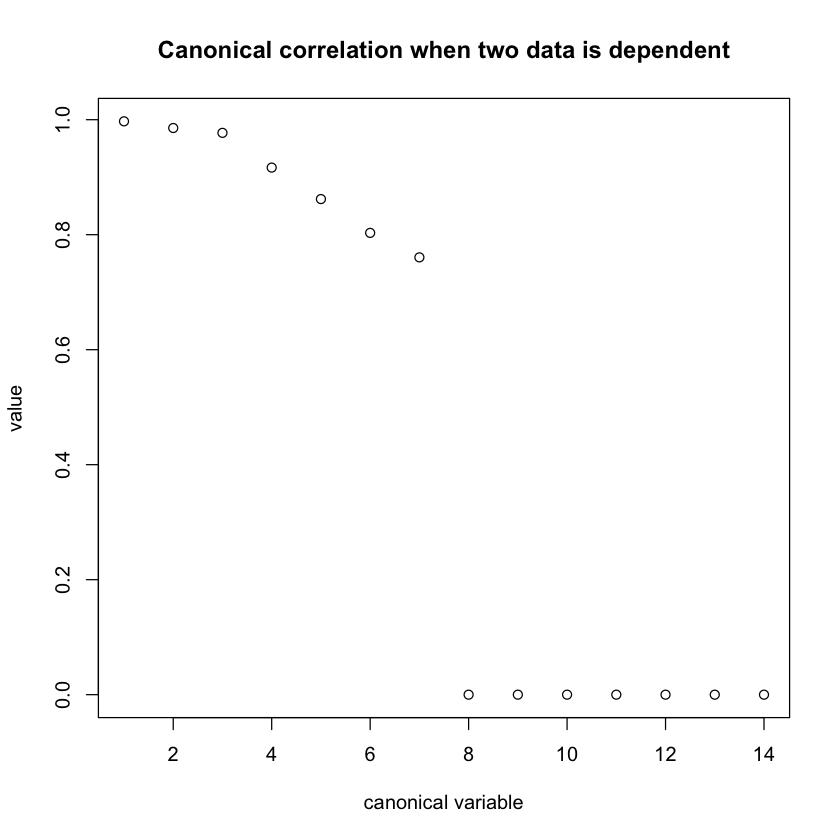

In [9]:




data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list, N_list, dependent=TRUE, addnoise=FALSE)
##compute mean of the data across p
data_mean <- utility.mean_data(data) # n \times p
##compute functional basis of each modality


km.est <- km.gen
#for(i in 1:length(km.est)){
    
#    if(km.est[i]  > k.gen){
#        km.est[i] <- k.gen
#    }
#}

k.est <- min(km.est)

fbasis_list <- list()
for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors
}
#data modality 1
bspline.basis1 <- create.bspline.basis(rangeval=c(0,1), nbasis=2*km.est[1])
d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=bspline.basis1)
#data modality 2
bspline.basis2 <- create.bspline.basis(rangeval=c(0,1), nbasis=2*km.est[2])
d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=bspline.basis2)

ccoar <- cca.fd(d1, d2)$ccacorr
print(ccoar)
par(bg="white")
plot(ccoar,xlab="canonical variable", ylab="value",main="Canonical correlation when two data is dependent")

[1] 0.48017178 0.14017411 0.06370490 0.03255892 0.02394519 0.01534972 0.01123866
[1] 0.47407894 0.14068827 0.06257291 0.03118275 0.02393040 0.01336739 0.01135939
[1] 1.0399335 0.9862997 0.9846308 0.9213203 0.8616866 0.8048058 0.7716612


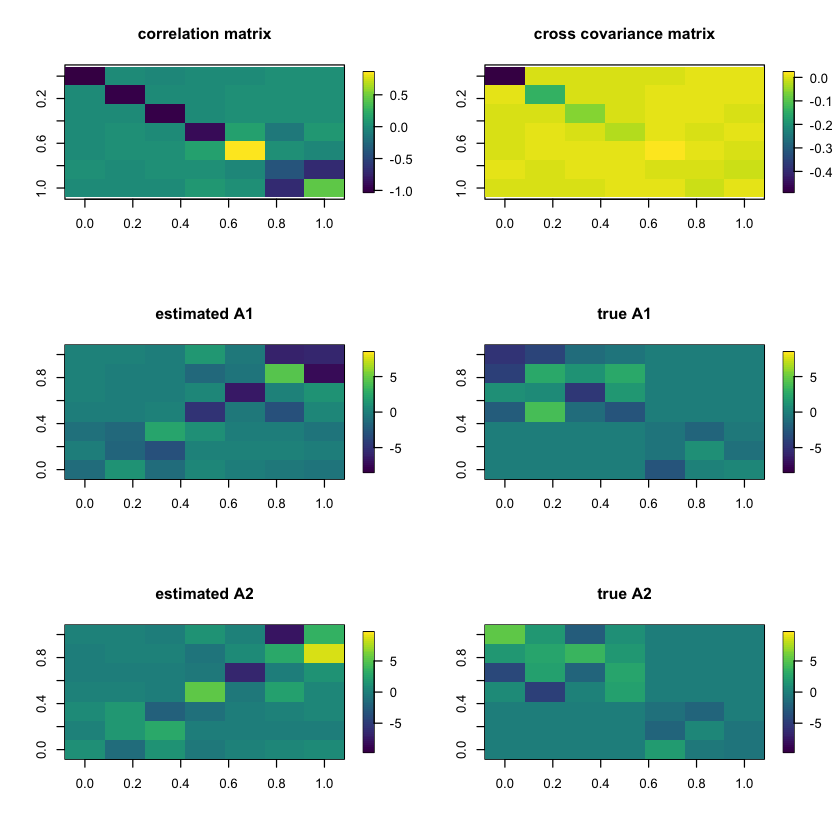

In [10]:

for(m in 1:M){
    #adjust number of basis to estimate
    temp_values <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values
    #print(paste("Number of km before adjustment", km.est[m]))
    km.est[m]<-length(which(temp_values>1e-8))
    #print(paste("Number of km after adjustment", km.est[m]))

    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors

    fvalue_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values[1:km.est[m]]
    print(fvalue_list[[m]])
    #par(bg="white")
    #plot(fbasis_list[[m]])
}

d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])
#data modality 2

d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=fbasis_list[[2]])
k.est <- min(km.est)

cca.r.m<- estimate.cca.matrix(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
cov.r.m <- cross.cov(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
par(bg="white", mfrow=c(3,2))
image.plot(cca.r.m, col=viridis(64),ylim=c(1.1,-0.1), main="correlation matrix")

image.plot(cov.r.m, col=viridis(64),ylim=c(1.1,-0.1), main="cross covariance matrix")
#print(A_list[[1]] %*% Apinv_list[[1]])


#cca.r.est <- estimate.cca(d1,d2,  true.basis_list[[1]],  true.basis_list[[2]], true.values_list[[1]], true.values_list[[2]], ncan=k.est)
cca.r.est <- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
print(cca.r.est$corr)

max_val = max(cca.r.est$A1, A_list[[1]]) + 1
min_val = min(cca.r.est$A1, A_list[[1]]) - 1
lim = max(max_val,abs(min_val))

image.plot(cca.r.est$A1, col=viridis(64), zlim = c(-lim, lim), main="estimated A1")
image.plot(A_list[[1]], col=viridis(64), zlim = c(-lim, lim),  main="true A1")


max_val = max(cca.r.est$A2, A_list[[2]]) + 1
min_val = min(cca.r.est$A2, A_list[[2]]) - 1
lim = max(max_val,abs(min_val))
#image.plot(cca.r.true$A2, col=viridis(64))
image.plot(cca.r.est$A2, col=viridis(64),zlim = c(-lim, lim), main="estimated A2")
image.plot(A_list[[2]], col=viridis(64),zlim = c(-lim, lim), main="true A2")


In [5]:
N.level = c(0.1,0.5,0.7,1.0,1.5,2.0)
fbasis_list <- list()
fvalue_list <- list()
run_simulation <- function(noise){

    for(m in 1:M){
        idx <- (1- seq(0,1,1 / (p*km.gen[m]-1)) ** 3)
        
        N_list[[m]] <-  diag(idx)*noise
    } 
    data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list, N_list, dependent=TRUE, addnoise=FALSE)
    ##compute mean of the data across p
    data_mean <- utility.mean_data(data) # n \times p
    for(m in 1:M){
        #adjust number of basis to estimate
        temp_values <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values
        #print(paste("Number of km before adjustment", km.est[m]))
        km.est[m]<-length(which(temp_values>1e-8))
        #print(paste("Number of km after adjustment", km.est[m]))

        fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors

        fvalue_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values[1:km.est[m]]
        print(fvalue_list[[m]])
    }
    print(paste("Noise level:", noise))
    d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])
    #data modality 2

    d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=fbasis_list[[2]])
    k.est <- min(km.est)

    cca.r.est <- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
    print(cca.r.est$corr)

    par(bg="white", mfrow=c(2,2))
    #image.plot(cca.r.true$A1, col=viridis(64))
    image.plot(cca.r.est$A1,ylim=c(1,0), col=viridis(64))
    image.plot(pinv(Apinv_list[[1]]), ylim=c(1,0), col=viridis(64))

    #image.plot(cca.r.true$A2, col=viridis(64))
    image.plot(cca.r.est$A2, ylim=c(1,0), col=viridis(64))
    image.plot(pinv(Apinv_list[[2]]), ylim=c(1,0), col=viridis(64))
}

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.54582851 0.41879891 0.21103293 0.13936079 0.09211481
[1] 0.5461656 0.4191388 0.2105984 0.1371870 0.0926928
[1] "Noise level: 0.1"
[1] 1.0074392 0.9969622 0.9953994 0.9900737 0.9817554
[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.54178474 0.37882088 0.27000508 0.16270602 0.07971339
[1] 0.55224694 0.37687377 0.26198310 0.16667775 0.08954257
[1] "Noise level: 0.5"
[1] 1.0085703 0.9861052 0.9767769 0.9629368 0.9297363


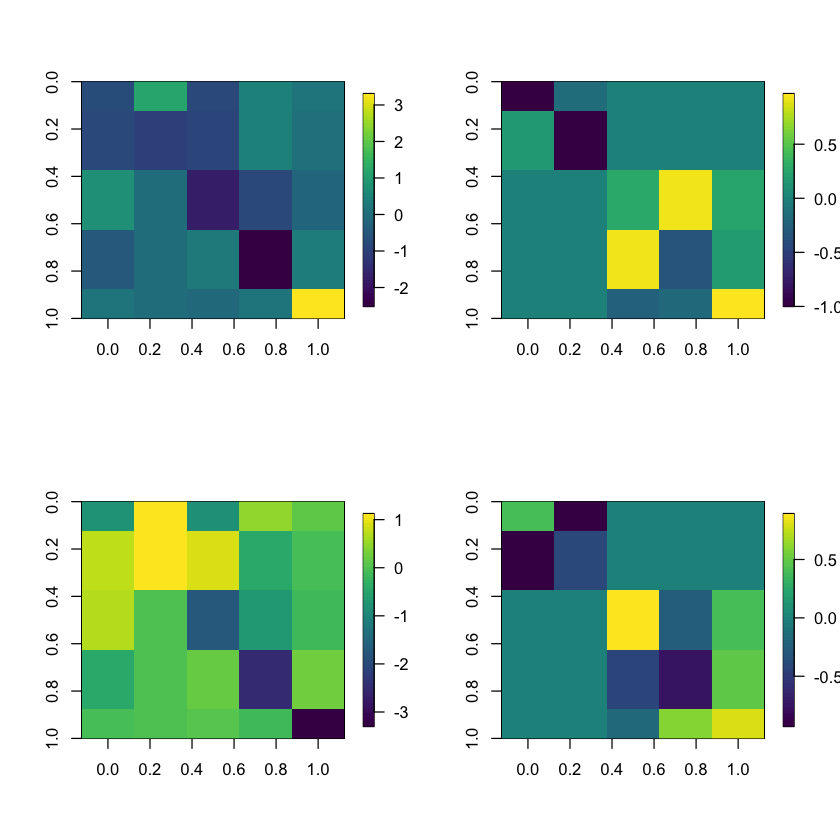

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.53672125 0.37686899 0.23761754 0.14055996 0.09511727
[1] 0.53707294 0.38929544 0.24111694 0.13876486 0.09228817
[1] "Noise level: 0.7"
[1] 1.0248071 0.9759242 0.9653730 0.9368971 0.8976888


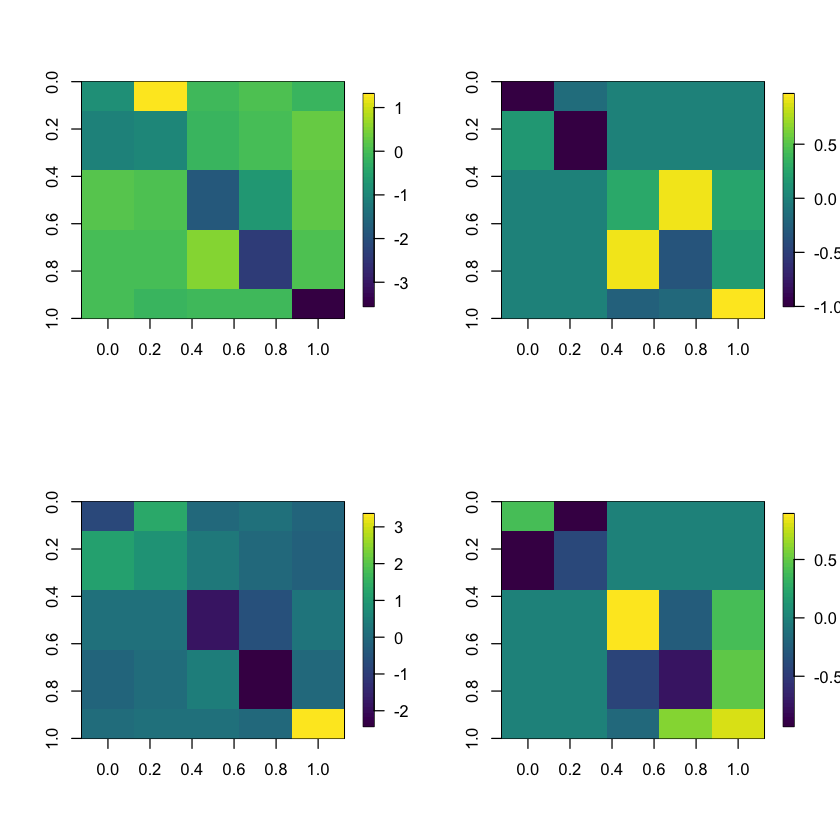

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.63246613 0.33040467 0.28493947 0.16381184 0.08551311
[1] 0.65033666 0.33962798 0.28149404 0.15710444 0.09472087
[1] "Noise level: 1"
[1] 0.9807115 0.9656648 0.9415718 0.9286354 0.8283075


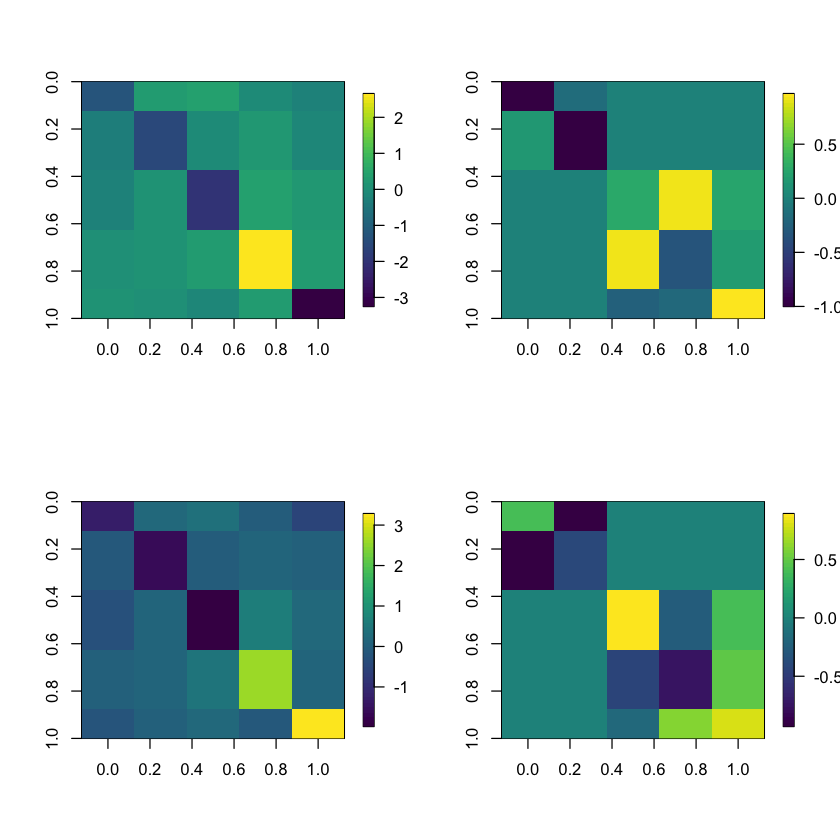

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.54949675 0.38541481 0.26849562 0.15501490 0.08149736
[1] 0.53334428 0.37018027 0.29528854 0.15170625 0.09242629
[1] "Noise level: 1.5"
[1] 0.9833988 0.9504415 0.9344135 0.8651810 0.7447009


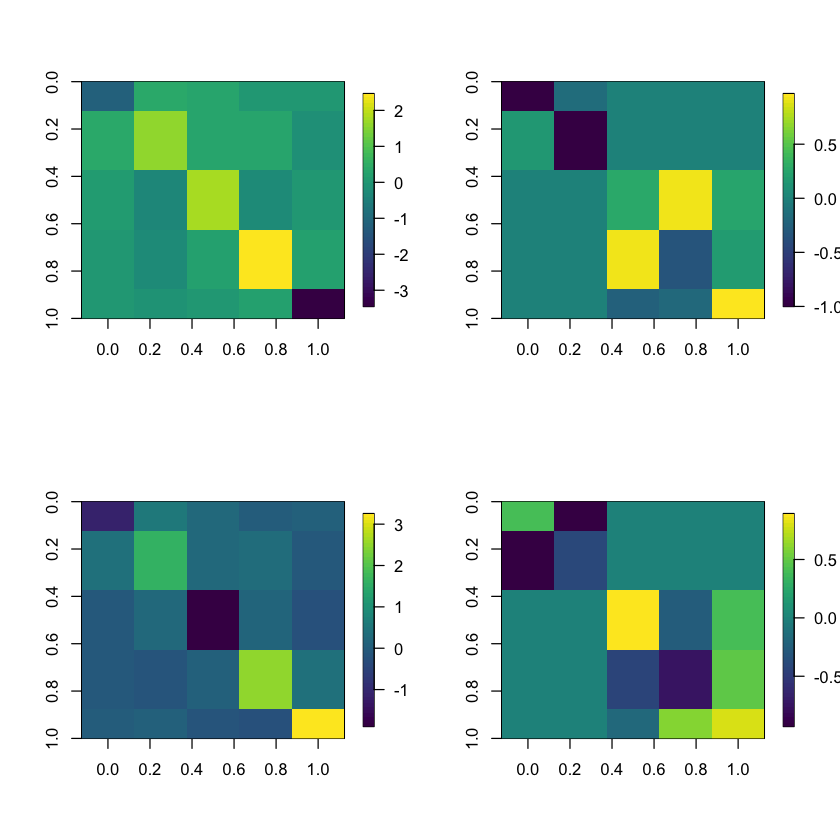

[1] "Generating data from modality 1"
[1] "Generating data from modality 2"
[1] 0.6244139 0.3929327 0.2767897 0.1923123 0.1090527
[1] 0.57083500 0.39182276 0.26769978 0.16393116 0.09998463
[1] "Noise level: 2"
[1] 0.9578603 0.9302787 0.8917237 0.8716687 0.7634098


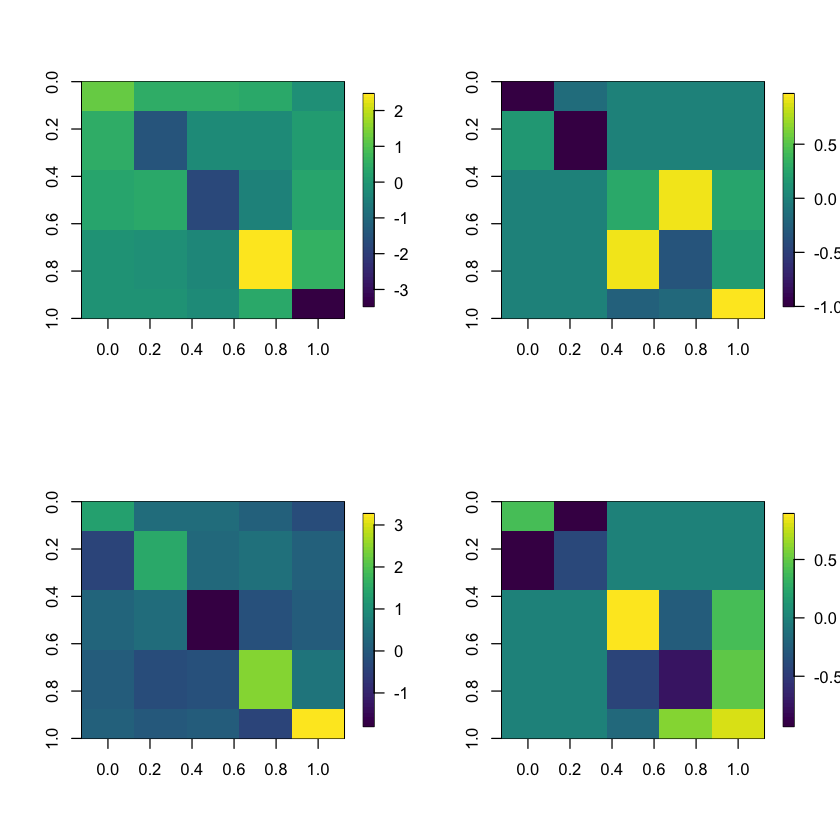

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

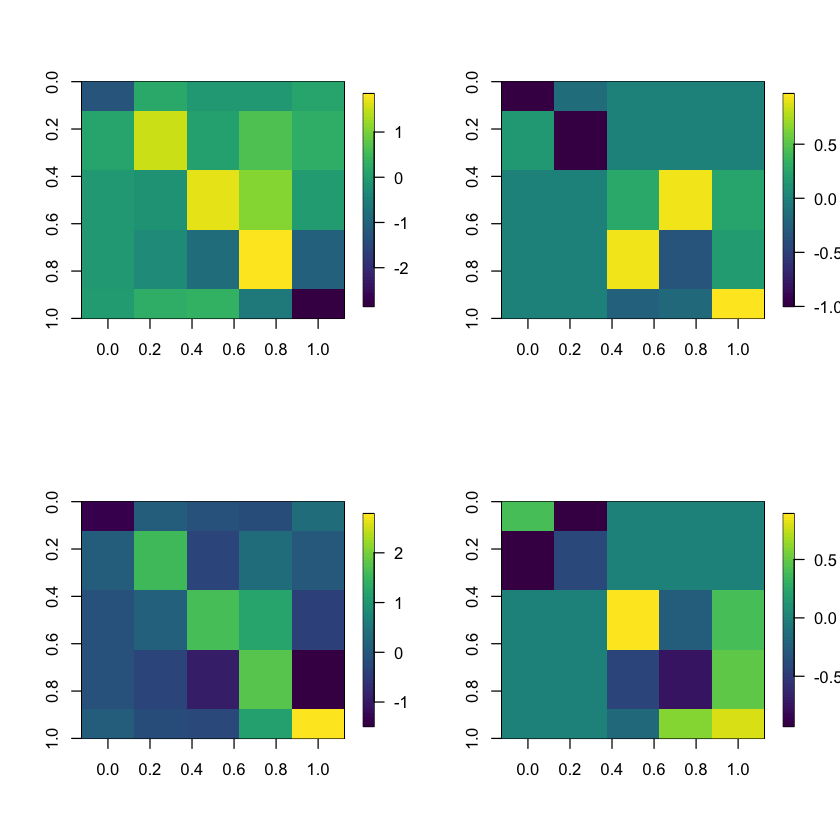

In [165]:
lapply(N.level,run_simulation)

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



In [588]:
fbasis_list <- list()
fvalue_list <- list()

for(m in 1:M){
    print(paste("Esimtating funcational basis of data modality",m))
    #adjust number of basis to estimate
    temp_values <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values
    #print(paste("Number of km before adjustment", km.est[m]))
    km.est[m]<-length(which(temp_values>1e-8))
    #print(paste("Number of km after adjustment", km.est[m]))

    fbasis_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$vectors

    fvalue_list[[m]] <- estimate.fpca.basis(c(0,1), obs.time, t(data_mean[[m]]), km.est[m], bs.nbasis=km.est[m]*3)$values[1:km.est[m]]
    print("Estimated Eigenvalues:")
    print(fvalue_list[[m]])
    print("True Eigenvalues:")
    print(true.values_list[[m]])
    
}

d1 <-Data2fd(argvals=obs.time, y=t(data_mean[[1]]), basisobj=fbasis_list[[1]])
#data modality 2

d2 <-Data2fd(argvals=obs.time, y=t(data_mean[[2]]), basisobj=fbasis_list[[2]])
k.est <- min(km.est)

cca.r.est <- estimate.cca(d1,d2,  fbasis_list[[1]],  fbasis_list[[2]], fvalue_list[[1]], fvalue_list[[2]], ncan=k.est)
#cca.r.true <- estimate.cca(d1,d2,  true.basis_list[[1]],  true.basis_list[[2]], true.values_list[[1]], true.values_list[[2]], ncan=k.est)

[1] "Esimtating funcational basis of data modality 1"
[1] "Estimated Eigenvalues:"
[1] 0.9879995 0.7780223 0.5443291 0.3716621 0.2536003 0.1479784 0.0800724
[1] "True Eigenvalues:"
[1] 1.04388422 0.78345590 0.56349783 0.38357665 0.24375036 0.14421766 0.08113739
[1] "Esimtating funcational basis of data modality 2"
[1] "Estimated Eigenvalues:"
[1] 0.98799360 0.77796406 0.54437536 0.37166440 0.25359769 0.14797858 0.08007231
[1] "True Eigenvalues:"
[1] 1.04388422 0.78345590 0.56349783 0.38357665 0.24375036 0.14421766 0.08113739


[1] 4.7113400 2.1090004 1.8492733 1.4789959 1.0916083 0.7359934 0.6426405
[8] 0.5751033 0.1137098
[1] 1.0043712 1.0010881 1.0004460 1.0004017 0.9995208 0.9994072 0.9988767


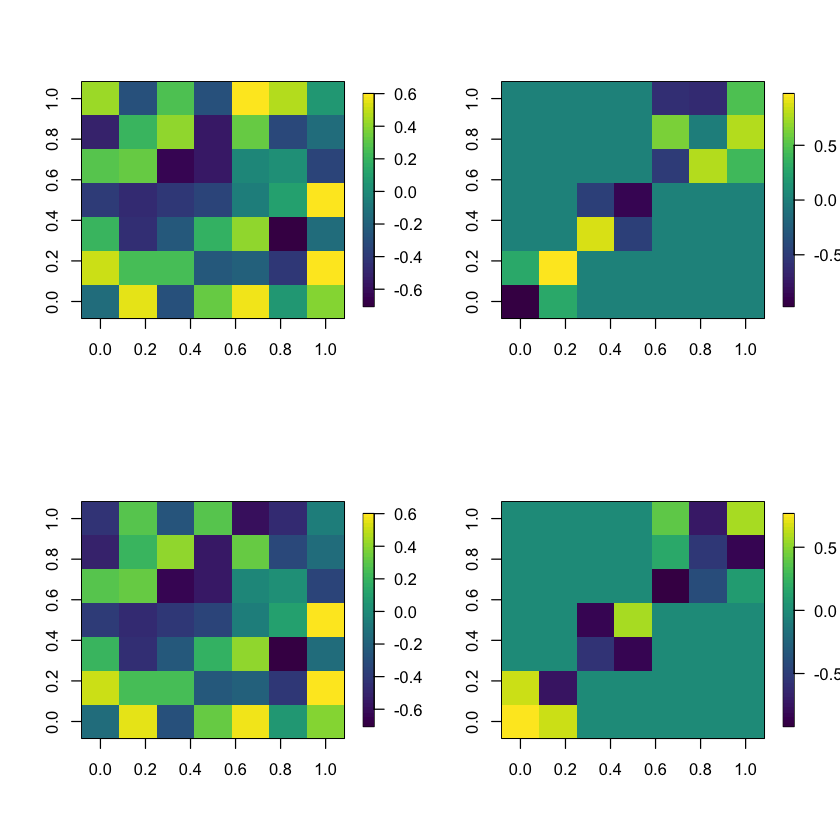

In [589]:
print(cca.r.true$corr)
print(cca.r.est$corr)
A1.est <- cca.result$A1
A2.est <- cca.result$A2
par(bg="white", mfrow=c(2,2))
#image.plot(cca.r.true$A1, col=viridis(64))
image.plot(cca.r.est$A1, col=viridis(64))
image.plot(pinv(Apinv_list[[1]]), col=viridis(64))

#image.plot(cca.r.true$A2, col=viridis(64))
image.plot(cca.r.est$A2, col=viridis(64))
image.plot(pinv(Apinv_list[[2]]), col=viridis(64))

In [51]:
dim(A1.est)
library(Matrix)

[1] 9 9

In [254]:

print(cca.r.est$A1)
print(pinv(Apinv_list[[1]]))

          [,1]       [,2]       [,3]      [,4]      [,5]
[1,] -2.158471 -0.5901647 -2.8835990 -0.317678 -1.054851
[2,]  3.910726 -1.1002009 -2.6038587 -4.918736  1.212655
[3,] -1.257334  2.5150928  3.6056202 -5.225598 -7.117123
[4,] -3.875397  8.8032380 -0.6786283 -3.251461  5.839099
[5,] -7.174596 -8.3065060  5.7354017 -5.569246  5.326808
            [,1]       [,2]       [,3]       [,4]       [,5]
[1,] -0.01820843  0.2678579  0.1676948  0.9160692 -0.2462038
[2,]  1.16742704 -0.9826507  0.8296883 -0.1062996 -0.9858140
[3,] -0.57341590  0.3267903 -1.6700100 -0.4363944 -2.3632665
[4,]  1.93739465  3.2453862  0.6485310 -1.1033017 -0.2758684
[5,]  3.11375728 -0.6461914 -3.4044611  1.2324032  1.3333338


In [415]:
cca.r.true$A2 %*% t(pinv(Apinv_list[[2]]))

-0.46599342,-0.23991410,0.51171215,0.26179252,-1.3076961,1.7465199,-0.21119625,-0.03127226,-0.38259692
-0.26985373,0.39897259,-0.29070662,-0.55961062,0.6350533,0.2281839,-1.17570402,1.40590440,-1.28809094
0.27610730,-1.83195040,-0.28997454,0.87766117,-0.2865512,-0.6169051,-1.38544972,-0.10196770,-0.03841239
-0.68688045,1.10442149,0.01351672,-0.01755255,0.3954894,0.1376096,-1.64939710,-1.60108149,0.46788372
-0.11426963,0.04258236,2.23750437,-0.88286630,-0.7174189,-1.0375158,-0.54967213,0.54585602,0.47571086
-1.53230423,0.69169528,-0.69308784,1.22629444,-0.6608683,-0.4776702,-0.08937717,1.39980090,1.35789126
-0.08228013,-1.09527969,0.08488138,-1.03521281,1.4114042,1.4263321,-0.26902033,0.61799656,1.97716845
2.32652327,1.16259160,0.85409329,1.81677752,0.4752127,0.6743438,-0.56672687,0.70578152,0.53200189
1.72246865,0.61690149,-1.80593367,-1.78211228,-2.0954657,-0.1110284,-0.78526536,0.24996053,0.94883907


In [286]:
ccafd <- varmx.cca.fd(cca.fd(d1, d2, ncan =5))
inprod(ccafd$weight1,fbasis_list[[1]])

-0.04969165,-0.085072824,-0.07341073,-0.042799322,-0.073997523
-0.02752917,0.076949592,-0.13388161,0.068538412,-0.177276836
0.01372614,-0.004394151,-0.11232963,-0.179009195,0.204277765
-0.08229756,0.033736623,0.05037012,-0.005693718,0.009260985
-0.01268770,0.036255152,0.08161574,-0.211513842,-0.156457781
